In [1]:
# Imports
import numpy as np
import os
import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, roc_curve
import seaborn as sns
from utils.audio_utils import MelSpectogramDataset


In [2]:
def calculate_metrics(y_true, y_pred_probs, num_classes):
    """
    Calculate AUC, precision, recall, and F1 score for multiclass classification.

    Args:
        y_true (array-like): True labels.
        y_pred_probs (array-like): Predicted probabilities or logits.
        num_classes (int): Number of classes in the classification task.

    Returns:
        dict: A dictionary containing AUC, precision, recall, and F1 scores.
    """
    # Convert predicted probabilities to class predictions
    y_pred = y_pred_probs.argmax(axis=1)

    # Calculate metrics
    metrics = {
        "AUC": roc_auc_score(y_true, y_pred_probs, multi_class="ovr", average="macro"),
        "Precision": precision_score(y_true, y_pred, average="macro", zero_division=1),
        "Recall": recall_score(y_true, y_pred, average="macro"),
        "F1 Score": f1_score(y_true, y_pred, average="macro")
    }
    return metrics


from sklearn.metrics import classification_report


def per_class_metrics(y_true, y_pred, num_classes):
    """
    Prints classification metrics for each class.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        num_classes (int): Number of classes in the classification task.
    """
    report = classification_report(
        y_true,
        y_pred,
        zero_division=1,
        target_names=[f"Class {i}" for i in range(num_classes)]
    )
    print(report)

In [3]:
# Evaluate the model on the test set
model = models.resnet18()
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=(1, 2), bias=True)
model.maxpool = nn.MaxPool2d((2, 3), stride=(1, 2))
model.fc = nn.Linear(512, 8)

model = model.to("mps")

model.load_state_dict(torch.load("models/resnet_model_v1_weighted_alphabetical.pt", weights_only=True))

<All keys matched successfully>

In [4]:
model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 2))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 3), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2

In [4]:
mel_dataset = MelSpectogramDataset(data_path='mel_spectrogram')
dataset_loader = DataLoader(mel_dataset, batch_size=32)

In [5]:

with torch.no_grad():
    correct, total = 0, 0
    all_labels, all_probs = [], []
    test_progress = tqdm.tqdm(dataset_loader, desc="Testing", leave=False)

    for mel_spectrogram, label in test_progress:
        mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
        output = model(mel_spectrogram.unsqueeze(1))
        probabilities = nn.Softmax(dim=1)(output).cpu().numpy()
        all_probs.append(probabilities)
        all_labels.append(label.cpu().numpy())
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()


    # Concatenate all predictions and true labels
    all_labels = np.concatenate(all_labels)
    all_probs = np.concatenate(all_probs)

    # Calculate metrics
    metrics = calculate_metrics(all_labels, all_probs, num_classes=8)
    print("OVERALL METRICS")

    print(f"Accuracy: {100 * correct / total:.2f}% | Metrics: {metrics}")

OVERALL METRICS
Accuracy: 15.67% | Metrics: {'AUC': 0.55601195288113, 'Precision': 0.152182886225801, 'Recall': 0.1491480905381276, 'F1 Score': 0.14549761469978212}


In [8]:
all_probs[291]

array([0.16464683, 0.20458728, 0.2276863 , 0.0122072 , 0.10550575,
       0.21234454, 0.00514981, 0.06787235], dtype=float32)

In [9]:
all_labels[0]

0

In [ ]:
y_pred[121]

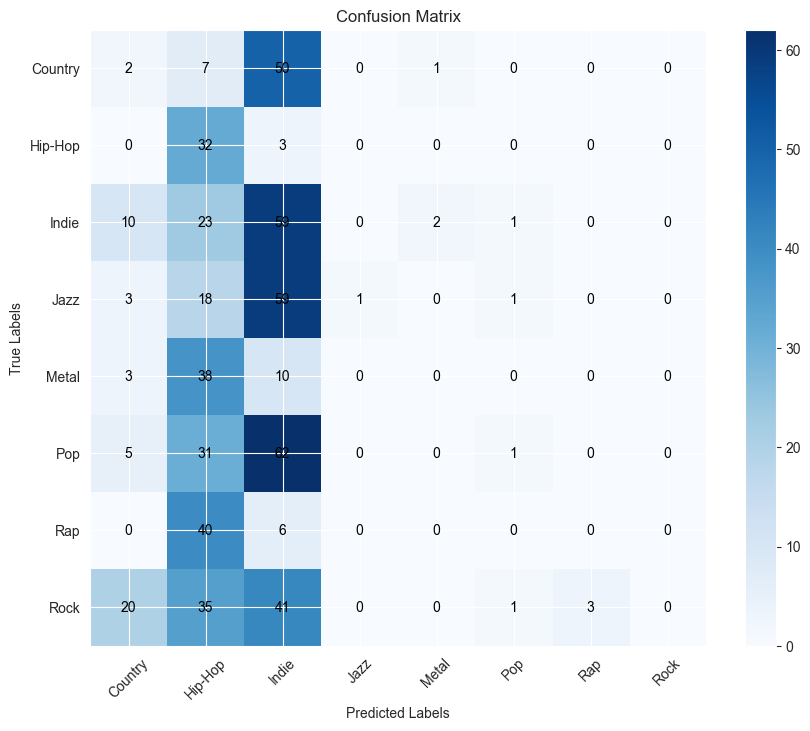

In [10]:
# Plot the confusion matrix with annotations on test set
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(all_labels, y_pred)

# Plot the confusion matrix with annotations
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(range(8), mel_dataset.genres, rotation=45)
plt.yticks(range(8), mel_dataset.genres)
for i in range(8):
    for j in range(8):
        plt.text(j, i, conf_matrix[i, j], ha="center", va="center", color="black")
plt.show()

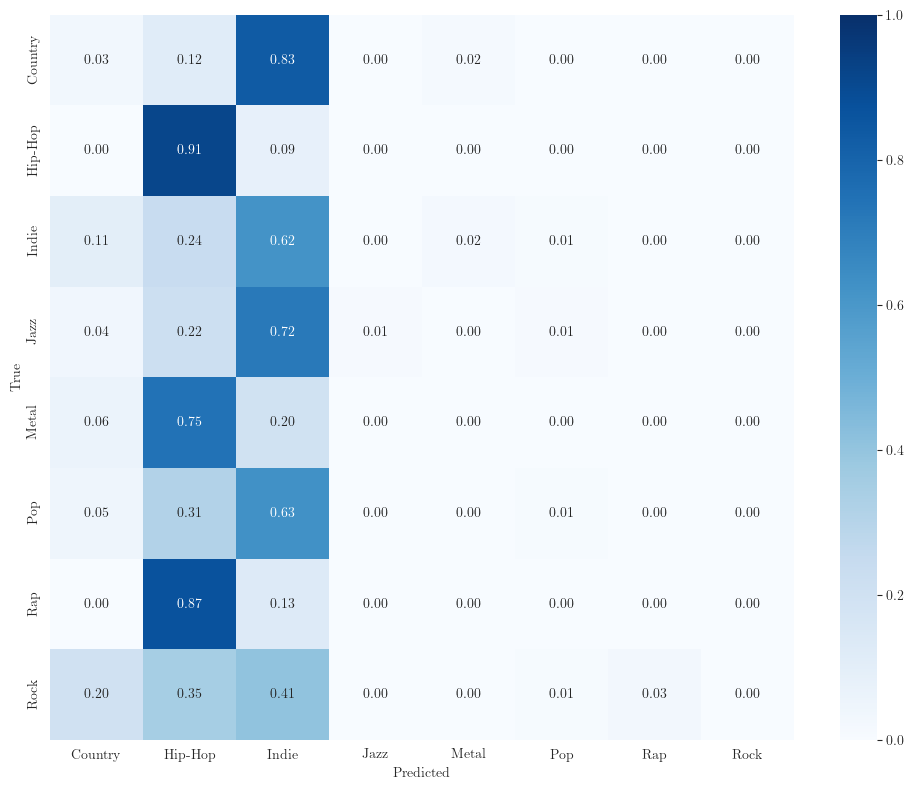

In [11]:
# Normalize the confusion matrix# 
conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_norm, cmap="Blues", annot=True, fmt=".2f", xticklabels=mel_dataset.genres,
            yticklabels=mel_dataset.genres, vmax=1.0)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("confusion_matrix_normalized_resnet.png", dpi=300)
plt.show()

In [14]:
# Load the data from csv for audio

from utils.audio_utils import MelSpectogramDataset

mel_dataset = MelSpectogramDataset(data_path='mel_spectrogram')
dataset_loader = DataLoader(mel_dataset, batch_size=32)
# Evaluate the model on the test set
audio_model = models.resnet18()
audio_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=(1, 2), bias=True)
audio_model.maxpool = nn.MaxPool2d((2, 3), stride=(1, 2))
audio_model.fc = nn.Linear(512, 8)

audio_model = audio_model.to("mps")

audio_model.load_state_dict(torch.load("models/resnet_model_v1_weighted_alphabetical.pt", weights_only=True))
# Get number of samples in test_loader

num_samples = 0
for mel_spectrogram, label in dataset_loader:
    num_samples += mel_spectrogram.size(0)
print(num_samples)

OVERALL METRICS
Accuracy: 15.67% | Metrics: {'AUC': 0.55601195288113, 'Precision': 0.152182886225801, 'Recall': 0.1491480905381276, 'F1 Score': 0.14549761469978212}


In [13]:
# Get predictions from the audio model
# Get predictions from the audio model
from tqdm import tqdm

criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    correct, total = 0, 0
    audio_preds, audio_labels = [], []
    test_progress = tqdm(dataset_loader, desc="Testing", leave=False)

    for mel_spectrogram, label in test_progress:
        mel_spectrogram, label = mel_spectrogram.to("mps").float(), label.to("mps")
        output = audio_model(mel_spectrogram.unsqueeze(1))
        probabilities = nn.Softmax(dim=1)(output).cpu().numpy()
        audio_preds.append(probabilities)
        audio_labels.append(label.cpu().numpy())
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        # Calculate the loss
        loss = criterion(output, label)
        test_progress.set_postfix({"Loss": f"{loss.item():.4f}"})

    # Concatenate all predictions and true labels
    audio_labels = np.concatenate(audio_labels)
    audio_preds = np.concatenate(audio_preds)

    # Calculate metrics
    metrics = calculate_metrics(audio_labels, audio_preds, num_classes=8)
    print("OVERALL METRICS")

    print(f"Accuracy: {100 * correct / total:.2f}% | Metrics: {metrics}")

OVERALL METRICS
Accuracy: 15.67% | Metrics: {'AUC': 0.55601195288113, 'Precision': 0.152182886225801, 'Recall': 0.1491480905381276, 'F1 Score': 0.14549761469978212}
